In [1]:
from gplearn import genetic
import gplearn as gp
import graphviz
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import talib
import gpfunc


In [2]:
row_df = pd.read_csv('BTCUSDT-1h.csv', index_col=0)
o = np.array(row_df['open'])
h = np.array(row_df['high'])
l = np.array(row_df['low'])
c = np.array(row_df['close'])
v = np.array(row_df['volume'])
df = row_df.copy()

In [3]:
# function_set = ['add', 'sub', 'mul', 'div',
#                 'sqrt', 'log', 'abs', 'neg', 'inv',
#                 'max', 'min', 'sin', 'cos', 'tan', 
#                 ]
function_set = []

In [4]:
ts_min = gpfunc.ts_min
ts_max = gpfunc.ts_max
ts_argmin = gpfunc.ts_argmin
ts_argmax = gpfunc.ts_argmax
ts_rank = gpfunc.ts_rank
ts_sum = gpfunc.ts_sum
ts_std = gpfunc.ts_std
func_list = {'ts_min':ts_min, 'ts_max':ts_max, 'ts_argmin':ts_argmin, 
             'ts_argmax':ts_argmax, 'ts_rank':ts_rank, 'ts_sum':ts_sum, 
             'ts_std':ts_std}
for f in func_list:
    function = gp.functions.make_function(function = func_list[f], name = f,arity = 1)
    function_set.append(function)
# function_set

In [5]:
def minmax_norm(df_input):
    return (df - df.min()) / ( df.max() - df.min())

In [6]:
data = row_df.iloc[:, 1:3]
cut = int(0.8*len(data))
x_train = np.array(data[:cut])
y_train = np.array(row_df['close'][1:cut+1]) - np.array(row_df['close'][:cut])
x_test = np.array(data[cut:-1])
y_test = np.array(row_df['close'][cut+1:]) - np.array(row_df['close'][cut:-1])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(31949, 2)
(31949,)
(7987, 2)
(7987,)


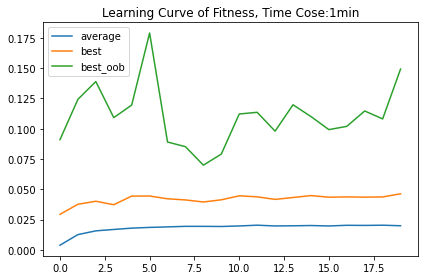

In [7]:
st = genetic.SymbolicTransformer(generations=20,  # 公式进化的世代数量
                          population_size=2000,  # 每一代生成因子数量
                          n_components=4,  # 最终筛选出的最优因子的数量
                          hall_of_fame=100,  # 备选因子的数量
                          function_set=function_set,  # 函数集
                          parsimony_coefficient=0.001,  # 节俭系数
                          tournament_size=20,  # 作为父代的数量
                          init_depth=(2, 6),  # 公式树的初始化深度
                          metric='pearson', # 适应度指标，可以用make_fitness自定义
                          const_range=(-1.0, 1.0),  # 因子中常数的取值范围
                          p_crossover=0.9,  # 交叉变异概率
                          p_subtree_mutation=0.03,  # 子树变异概率
                          p_hoist_mutation=0.03,  # Hoist 变异概率
                          p_point_mutation=0.03,  # 点变异概率
                          p_point_replace=0.05,  # 点替代概率                         
                          max_samples=0.9,  # 最大采样比例
                          feature_names=data.columns,
                          verbose=0,
                          random_state=123,  # 随机数种子
                          n_jobs=6,  # 并行计算使用的核心数量
                         )
out = st.fit(x_train, y_train)
df_statistics = pd.DataFrame(st.run_details_)

# 画学习曲线
duration = df_statistics['generation_time'].sum() / 60
x = df_statistics['generation']
plt.plot(x, df_statistics['average_fitness'], label='average')
plt.plot(x, df_statistics['best_fitness'], label='best')
plt.plot(x, df_statistics['best_oob_fitness'], label='best_oob')
plt.title('Learning Curve of Fitness, Time Cose:%.0fmin' % duration)
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [8]:
from io import StringIO 
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout
with Capturing() as output:
    print(st._best_programs[0])
output = output[0]

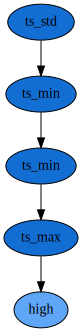

In [9]:
# for func in st._best_programs:
#     dot_data = func.export_graphviz()
#     graph = graphviz.Source(dot_data)
#     display(graph)
display(graphviz.Source(st._best_programs[0].export_graphviz()))

In [10]:
from basicfunc import *
converter = {
    'sub': sub,
    'div': div,
    'mul': mul,
    'add': add,
    'neg': neg,
    'pow': pow
}
import sympy
sympy.sympify(output, locals=converter)

ts_std(ts_min(ts_min(ts_max(high))))

In [11]:
output

'ts_std(ts_min(ts_min(ts_max(high))))'

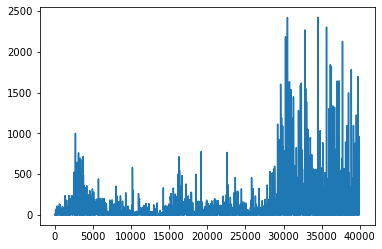

In [12]:
open = np.array(df['open'])
low =  np.array(df['low'])
high =  np.array(df['high'])
close =  np.array(df['close'])
volume =  np.array(df['volume'])

result = np.array(eval(output))
plt.plot(result)

high    0.408999
low     0.407085
Name: target_func, dtype: float64

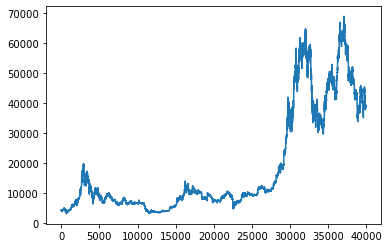

In [13]:
evalute_df = data.copy()
evalute_df['target_func'] = result
# 找到相关性绝对值最强的列
corr = evalute_df.corr()['target_func'].sort_values(ascending=False)[1:].abs().sort_values(ascending=False)
plt.plot(np.array(df[corr.index[0]]))
corr